# Pattern reconstruction with energy minimization using Monte Carlo methods and Metropolis algorithm


In this section, we will perform pattern reconstruction by employing stochastic approaches such as the Monte Carlo method, with the Metropolis algorithm as a tool for this purpose.
Each stored pattern corresponds to a local minimum in the network's energy landscape, and the network evolves towards these minima from an initial corrupted configuration.
The energy of a Hopfield network is given by:

<p align="center"> 
\[ E = -\frac{1}{2} \sum_{i \neq j} J_{ij} S_i S_j \]
</p>

The Monte Carlo method consists of first randomly sampling a spin in the pattern and then applying Metropolis algorithm, where iteratively the states of the spins are updated based on transition probabilities that favor moves towards lower energy configurations while still allowing occasional uphill moves.

Metropolis algorithm works in this way:
1. For each randomly selected spin, we compute the energy difference $\Delta E$ between the patterns' configuration with that spin and the one with the spin flipped. In particular,  $\Delta E$ in this context si equal to:
<p align="center"> 
\[ \Delta E = 2 S_i \big( \sum_{j = 1}^N J_{ij} S_j \big) \]
</p>
2. If $\Delta E$ is negative, we accpet the spin flip. If not, we generate a random number x from a uniform distribution $\in$ [0,1] and we accept the spin flip if x < $\exp(-\beta \Delta E)$.
Here $\beta$ = $\frac{1}{T}$ (we have set $K_b$ = 1).

The parameter $\beta$ controls the probability of accepting a move that increases energy (which is given by the exponential Boltzmann factor). 
In this analysis we will study the stability of the system and the retrieval ability of the network.

**Note**: In the following sections, we will use the Mattis overlap order parameter [1], defined as:
<p align="center"> 
\[ m_\mu = \frac{1}{N} \sum_{i=1}^{N} S_i^{(\mu)} S_i \]
</p>

to compute the overlap between the retrieved pattern and the stored ones. When we refer to **accuracy**, we mean the correct fraction of the **retrieved pattern** compared to the **selected original pattern**. The term **overlap**, instead, refers to the degree of similarity between the retrieved pattern and the other stored patterns.

**Bibliography:**

[1] Fachechi, A., Agliari, E. & Barra, A. Dreaming neural networks: forgetting spurious memories
and reinforcing pure ones. Neural Networks 112, 24–40 (2019).



In [33]:
#import necessary libraries
import numpy as np
import matplotlib.pyplot as plt

## Functions for 1D patterns

In [34]:
def create_patterns_1d(N_spins,mu): #mu patterns, each one composed by N_spins spins
    patterns = np.array([np.random.randint(0,2,N_spins) * 2 -1 for i in range(mu)])
    return patterns

def compute_weights_1d(patterns): #compute the weight matrix
    N_spins = patterns.shape[1]
    weight_matrix = (1/N_spins) * np.outer(patterns[0],patterns[0])
    for i in range(1,patterns.shape[0]):
        weight_matrix += (1/N_spins) * np.outer(patterns[i],patterns[i])
    np.fill_diagonal(weight_matrix, 0)
    return weight_matrix

def compute_energy_1d(pattern, weights): #compute the energy
    E = -0.5 * np.dot(pattern, np.dot(weights, pattern))
    return E

def pattern_corruption_1d(pattern,q): #randomly flip a fraction of the spins in a pattern
    corrupted = pattern.copy()
    flip_numbers = int(len(pattern) * q)
    flip_indexes = np.random.choice(len(pattern), flip_numbers, replace = False)
    corrupted[flip_indexes] *= -1
    return corrupted

def metropolis_1d(corrupted, weights, T, steps): #MonteCarlo + Metropolis
    beta = 1/T
    pattern_copy = corrupted.copy()
    
    for _ in range(steps):
        i = np.random.randint(0,len(corrupted))
        hi = np.sum(weights[i] * pattern_copy)
        Delta_E = 2 * pattern_copy[i] * hi
        x = np.random.random()
        
        #Metropolis condition:
        if Delta_E < 0 or x < np.exp(-beta * Delta_E):
            pattern_copy[i] *= -1
    return pattern_copy

def select_pattern_1d(patterns): #choose randomly a pattern
    return np.random.randint(0,len(patterns))

def mattis_overlap_1d(pattern, retrieved): #compute the Mattis overlap
    return (1/len(pattern)) * np.dot(pattern.reshape(-1),retrieved.reshape(-1))



## Functions for 2D patterns

In [35]:
def create_patterns_2d(rows,columns,N_patterns): #mu patterns, each one composed by a matrix of rows x columns spins
    patterns = []
    for _ in range(N_patterns):
        pattern = np.random.randint(0,2,size = (rows,columns)) * 2 -1
        patterns.append(pattern)
    return np.array(patterns)


def compute_weights_2d(patterns): #compute the weight matrix
    N_spins = patterns.shape[1] * patterns.shape[2]
    weight_matrix = (1/N_spins) * np.outer(patterns[0],patterns[0])
    for i in range(1,patterns.shape[0]):
        weight_matrix += (1/N_spins) * np.outer(patterns[i],patterns[i])
    np.fill_diagonal(weight_matrix, 0)
    return weight_matrix

def compute_energy_2d(pattern, weights): #compute the energy
    E = -0.5 * np.dot(pattern.reshape(-1), np.dot(weights, pattern.reshape(-1))) #flattens the matrix in a 1d array
    return E

def pattern_corruption_2d(pattern,q): #randomly flip a fraction of the spins in a pattern
    rows = pattern.shape[0]
    columns = pattern.shape[1]
    corrupted = pattern.reshape(-1).copy()
    flip_numbers = int(np.floor((len(corrupted) * q)))
    flip_indices = np.random.choice(len(corrupted), flip_numbers, replace = False)
    corrupted[flip_indices] *= -1
    return corrupted.reshape(rows,columns)

def metropolis_2d(corrupted, weights, T, steps): #MonteCarlo + Metropolis
    beta = 1/T
    rows = corrupted.shape[0]
    columns = corrupted.shape[1]
    pattern_copy = corrupted.reshape(-1).copy()
    
    for _ in range(steps):
        i = np.random.randint(0,rows * columns)
        hi = np.sum(weights[i] * pattern_copy)
        Delta_E = 2 * pattern_copy[i] * hi
        x = np.random.random()
        
        #Metropolis condition:
        if Delta_E < 0 or x < np.exp(-beta * Delta_E):
            pattern_copy[i] *= -1
    return pattern_copy.reshape(rows,columns)

def select_pattern_2d(patterns): #choose randomly a pattern
    return np.random.randint(0,patterns.shape[0])

def mattis_overlap_2d(pattern, retrieved): #compute the Mattis overlap
    N_spins = pattern.shape[0] * pattern.shape[1]
    return (1/N_spins) * np.dot(pattern.reshape(-1),retrieved.reshape(-1))

## 1) Stability analysis

With the term "stability" we mean the ability of the algorithm to converge to the correct pattern given as input exactly one of the stored pattern.
We will check it for:
- Different range of **temperatures**
- Different number of **iterations** of the Metropolis algorithm

### Stability for different temperatures

First we store some patterns in the network:

In [55]:
#Store patterns in memory
# for reproducibility
np.random.seed(1234)
runs = 100 #number of simulations for a given value of T

rows,columns = 10,10 #patterns are square matrix with 100 spins
N_patterns = 6 #number of stored patterns
patterns = create_patterns_2d(rows,columns,N_patterns) 
J = compute_weights_2d(patterns) #compute the weight matrix of the stored patterns

We now check the stability of the retrieval for different values of temperature:

<ErrorbarContainer object of 3 artists>

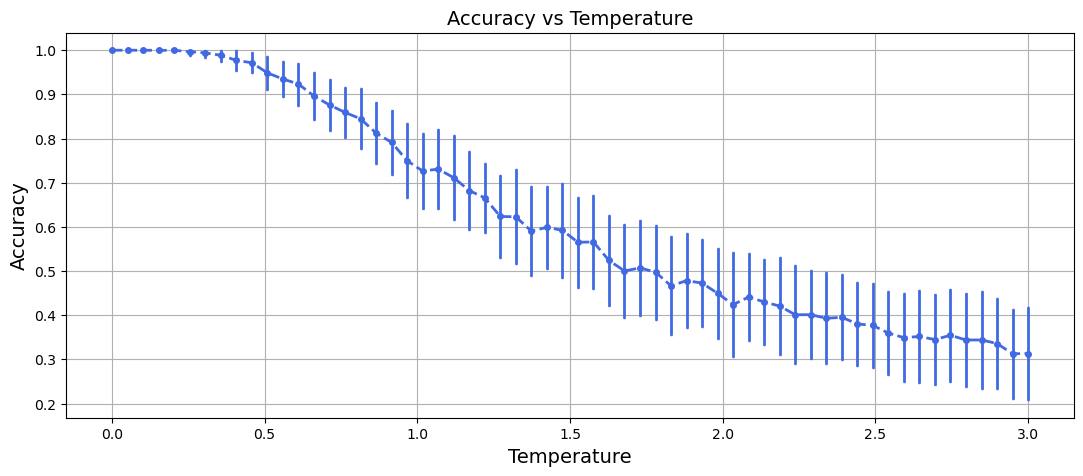

In [77]:
steps = 100 #steps for the Metropolis algorithm
T = np.linspace(0.001,3,60) #array of temperatures
accuracy_list = [] #we will check accuracy by the use of Matti's order parameter
upper_errors = [] #store upper error bounds
lower_errors = [] #store lower error bounds

for temperature in T:
    accuracy = []
    for _ in range(runs): #we compute the accuracy "runs" times for each temperature and then take the mean
        i = select_pattern_2d(patterns)
        corrupted = pattern_corruption_2d(patterns[i],0) # zero corruption of the pattern
        retrieved = metropolis_2d(corrupted,J,temperature,steps)
        accuracy.append(mattis_overlap_2d(patterns[i],retrieved))
    
    accuracy = np.array(accuracy)
    accuracy_mean = np.mean(accuracy)
    accuracy_std = np.std(accuracy)
    
    # Compute physically meaningful error bars
    upper_err = min(accuracy_std, 1 - accuracy_mean)
    lower_err = min(accuracy_std, accuracy_mean + 1)
    
    accuracy_list.append(accuracy_mean)
    upper_errors.append(upper_err)
    lower_errors.append(lower_err)

#Plotting the results
plt.figure(figsize = (13,5))
plt.grid()
plt.title("Accuracy vs Temperature", fontsize = 14)
plt.xlabel("Temperature", fontsize = 14)
plt.ylabel("Accuracy", fontsize = 14)
plt.errorbar(T, np.array(accuracy_list), yerr=[lower_errors, upper_errors], marker='o', linestyle="--",  linewidth=2, 
            markersize=4, capsize=1, color="royalblue")

From the plot, we observe a stable retrieval phase for T $\in$ (0,0.5]. This behavior is expected, as lower values of T minimize perturbations, allowing the system to follow a more deterministic evolution. Conversely, higher values of T increase the likelihood of random, undesired spin flips, compromsing the stability of the process.

Since we have identified a suitable temperature range, we can now examine how stability depends on the number of iterations in the Monte Carlo method, because running the algorithm for many steps is likely to increase the probability of random spin flips.

### Stability for different numbers of iterations

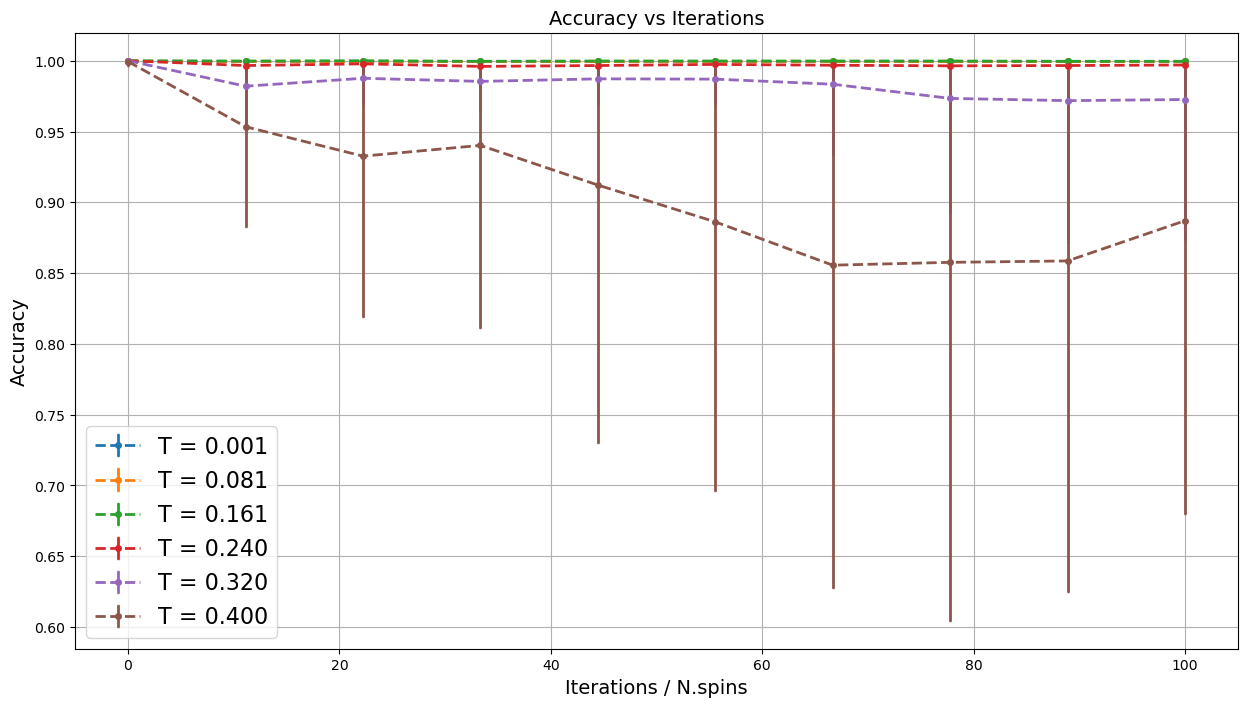

In [6]:
steps = np.linspace(1, 10000, 10, dtype='int')  #steps for the Metropolis algorithm
fractions = steps / (rows * columns)  #ratio between iterations and spins
T = np.linspace(0.001, 0.4, 6)  #range of temperatures to check

plt.figure(figsize=(15, 8))
runs = 100

for temperature in T:
    accuracy_list = []
    upper_errors = []
    lower_errors = []
    
    for step in steps:
        accuracy = []
        for _ in range(runs):
            i = select_pattern_2d(patterns)
            corrupted = pattern_corruption_2d(patterns[i], 0)
            retrieved = metropolis_2d(corrupted, J, temperature, step)
            accuracy.append(mattis_overlap_2d(patterns[i], retrieved))
            
        accuracy_mean = np.mean(accuracy)
        accuracy_std = np.std(accuracy)
        
        # Compute physically meaningful error bars
        upper_err = min(accuracy_std, 1 - accuracy_mean)
        lower_err = accuracy_std
        
        accuracy_list.append(accuracy_mean)
        upper_errors.append(upper_err)
        lower_errors.append(lower_err)
    
    # Plotting with asymmetric error bars
    plt.errorbar(fractions, np.array(accuracy_list), yerr=[lower_errors, upper_errors], marker='o', linestyle="--", 
                 markersize=4, linewidth=2, label=f"T = {temperature:.3f}", capsize=1)

plt.grid()
plt.title("Accuracy vs Iterations", fontsize=14)
plt.xlabel("Iterations / N.spins", fontsize=14)
plt.ylabel("Accuracy", fontsize=14)
plt.legend(prop={'size': 16}, loc='best')

So we see that appoximately for T $\le$ 0.3 (i. e. $\beta$ $\ge$ 3.3 ) the model is sufficiently stable for approximately an arbitrary number of iterations of the Metropolis algorithm.
For the further analysis we fix the temperature at T = 0.1 ($\beta$ = 10).

### Overlaps with other patterns

Using the Mattis overlap order parameter, we can analyze how overlaps behave in the problematic temperature and iteration ranges we identified. 

#### a)  Overlaps for high temperatures & appropriate number of iterations

In [65]:
#Check for overlaps
overlaps = []
T = 1.5 #fix t
steps = 100
n_chosen = select_pattern_2d(patterns) #choose a random pattern
retrieved = metropolis_2d(patterns[n_chosen],J,T,steps)
for pattern in patterns:
    overlap = mattis_overlap_2d(retrieved,pattern)
    overlaps.append(overlap)
overlaps = np.array(overlaps)

selected pattern number: 4, retrieved pattern number: 4, with accuracy: 0.74


Text(0, 0.5, 'Overlap Value')

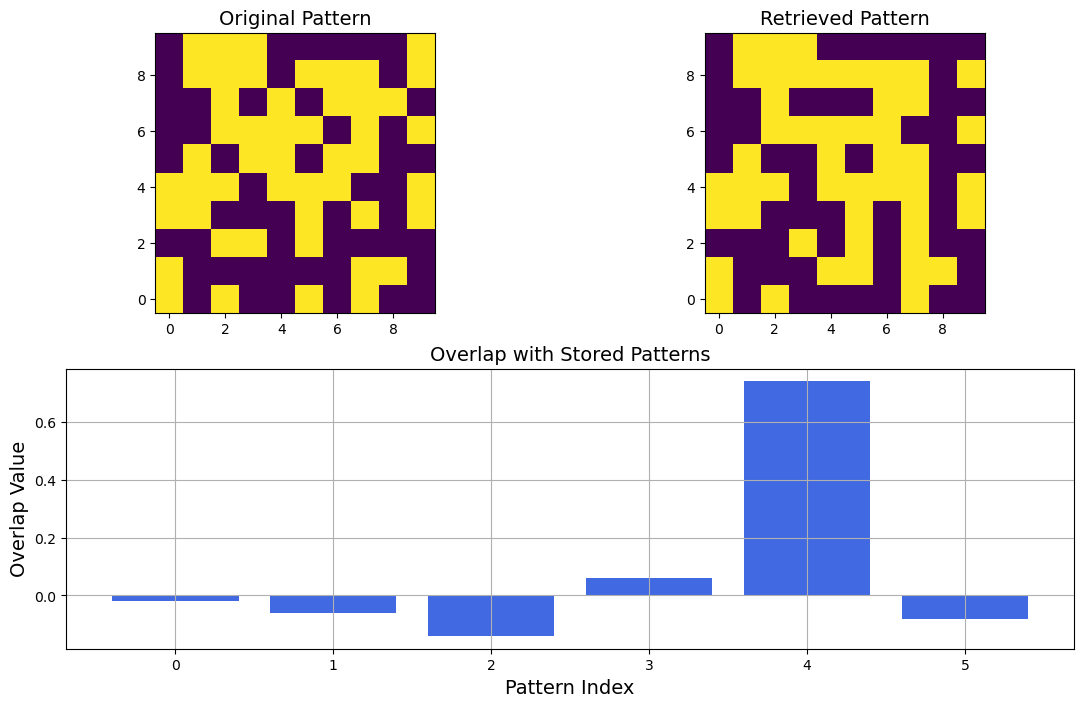

In [66]:
#visualization:

fig = plt.figure(figsize=(13, 8))
# Upper row: Original and Retrieved pattern
ax1 = plt.subplot2grid((2, 2), (0, 0))  
ax2 = plt.subplot2grid((2, 2), (0, 1))  
# Bottom row: Overlap plot
ax3 = plt.subplot2grid((2, 2), (1, 0), colspan=2)  

#print the accuracy of the retrieval
print(f"selected pattern number: {n_chosen}, retrieved pattern number: {np.argmax(overlaps)}, with accuracy: {overlaps[n_chosen]}")

#plot original and retrieved pattern
ax1.imshow(patterns[n_chosen], origin='lower')
ax1.set_title("Original Pattern", fontsize=14)

ax2.imshow(retrieved, origin='lower')
ax2.set_title("Retrieved Pattern", fontsize=14)

# Plot overlaps in the bottom subplot
ax3.grid()
ax3.bar(range(len(overlaps)), overlaps, color="royalblue")
ax3.set_title("Overlap with Stored Patterns", fontsize=14)
ax3.set_xlabel("Pattern Index", fontsize=14)
ax3.set_ylabel("Overlap Value", fontsize=14)

Now we can compute statistics on the system's ability to retrieve the correct pattern: we run 100 simulations of the previous process and we consider the retrieved pattern the one with the highest overlap value:

In [67]:
correct_retrieve = []
for _ in range(runs):
    overlaps = []
    i = select_pattern_2d(patterns)
    corrupted = pattern_corruption_2d(patterns[i],0) # zero corruption of the pattern
    retrieved = metropolis_2d(corrupted,J,T,steps)
    for pattern in patterns:
        overlap = mattis_overlap_2d(retrieved,pattern)
        overlaps.append(overlap)
    if (np.argmax(overlaps) == i):
        correct_retrieve.append(True)
    else:
        correct_retrieve.append(False)

correct_retrieve = np.array(correct_retrieve)
print("Fraction of correct retrieve:", np.mean(correct_retrieve))

Fraction of correct retrieve: 1.0


So, if we select a temperature above the range identified previously, the network can still retrieve the correct pattern in most cases, but with reduced accuracy. This loss in accuracy increases proportionally with temperature (as we have seen in the first plot).

In this regime, there is no significant overlap between the retrieved pattern and the other stored patterns, as confirmed by the "bar plot", which shows distinction in overlap values. This suggests that while retrieval is still possible at higher temperatures, the precision of the recalled pattern decreases due to increased randomness in spin updates.

#### b) Overlaps for high temperatures & high number of iterations

In [68]:
#Check for overlaps
overlaps = []
T = 1.5
steps = 1000 #add a factor 10 to the steps
n_chosen = select_pattern_2d(patterns) #choose a random pattern
retrieved = metropolis_2d(patterns[n_chosen],J,T,steps)
for pattern in patterns:
    overlap = mattis_overlap_2d(retrieved,pattern)
    overlaps.append(overlap)
overlaps = np.array(overlaps)

selected pattern number: 4, retrieved pattern number: 4, with accuracy: 0.22


Text(0, 0.5, 'Overlap Value')

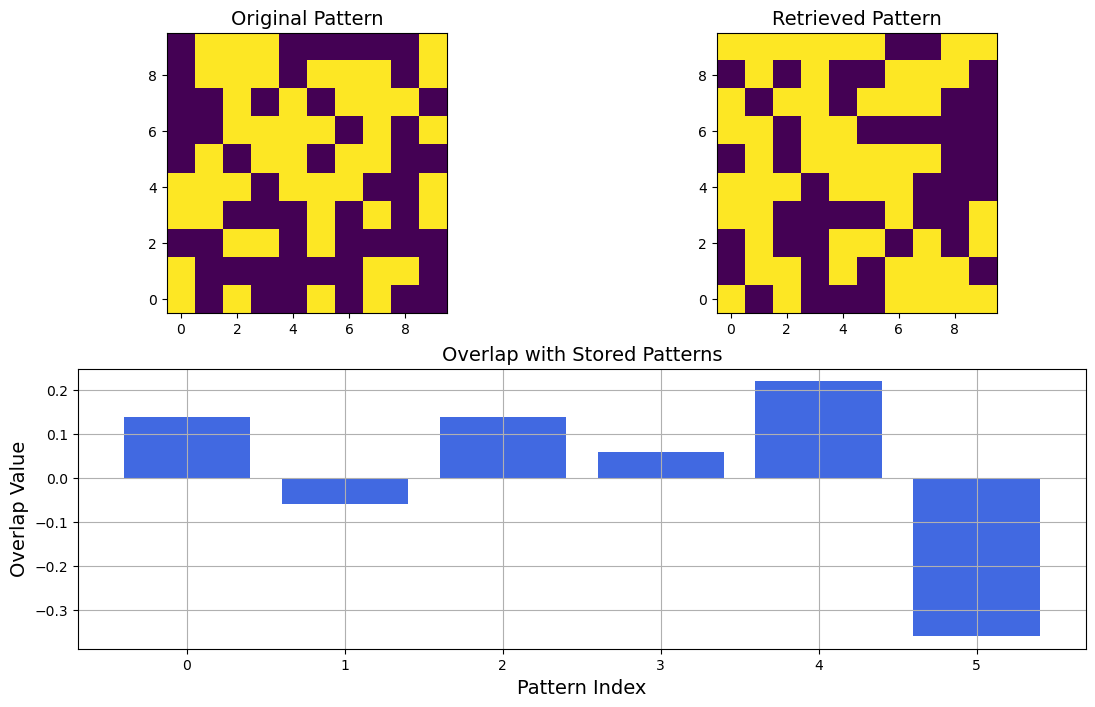

In [69]:
#visualization
fig = plt.figure(figsize=(13, 8))

# Upper row: Original and Retrieved pattern
ax1 = plt.subplot2grid((2, 2), (0, 0))
ax2 = plt.subplot2grid((2, 2), (0, 1))

# Bottom row: Overlap plot
ax3 = plt.subplot2grid((2, 2), (1, 0),colspan = 2) 
#ax4 = plt.subplot2grid((2, 2), (1, 1))
print(f"selected pattern number: {n_chosen}, retrieved pattern number: {np.argmax(overlaps)}, with accuracy: {overlaps[n_chosen]}")

#plot original and retrieved pattern
ax1.imshow(patterns[n_chosen], origin='lower')
ax1.set_title("Original Pattern", fontsize=14)

ax2.imshow(retrieved, origin='lower')
ax2.set_title("Retrieved Pattern", fontsize=14)

# Plot overlaps in the bottom subplot
ax3.grid()
ax3.bar(range(len(overlaps)), overlaps, color="royalblue")
ax3.set_title("Overlap with Stored Patterns", fontsize=14)
ax3.set_xlabel("Pattern Index", fontsize=14)
ax3.set_ylabel("Overlap Value", fontsize=14)


As before we check the fraction of correct retrieved patterns: 

In [70]:
correct_retrieve = []
for _ in range(runs):
    overlaps = []
    i = select_pattern_2d(patterns)
    corrupted = pattern_corruption_2d(patterns[i],0) # zero corruption of the pattern
    retrieved = metropolis_2d(corrupted,J,T,steps)
    for pattern in patterns:
        overlap = mattis_overlap_2d(retrieved,pattern)
        overlaps.append(overlap)
    if (np.argmax(overlaps) == i):
        correct_retrieve.append(True)
    else:
        correct_retrieve.append(False)

correct_retrieve = np.array(correct_retrieve)
print("Fraction of correct retrieve:",np.mean(correct_retrieve))

Fraction of correct retrieve: 0.24


For excessive iterations at moderate-to-high temperatures the probability of random spin flips increases over time, causing the overlap to degrade as the system moves away from the stored pattern.

In the next section we will evaluate the network's ability to retrieve a stored pattern from a corrupted version by introducing some noise. This will help us understanding how the system well the system can retrieve a stored pattern and within what limits.

## 2) Analysis of retrieval ability

For the next steps, the function **"pattern_corruption"** flips randomly a fraction **q** of the spins in the pattern.
Here we can see an example of this procedure:

Accuracy of the retrieval: 1.00


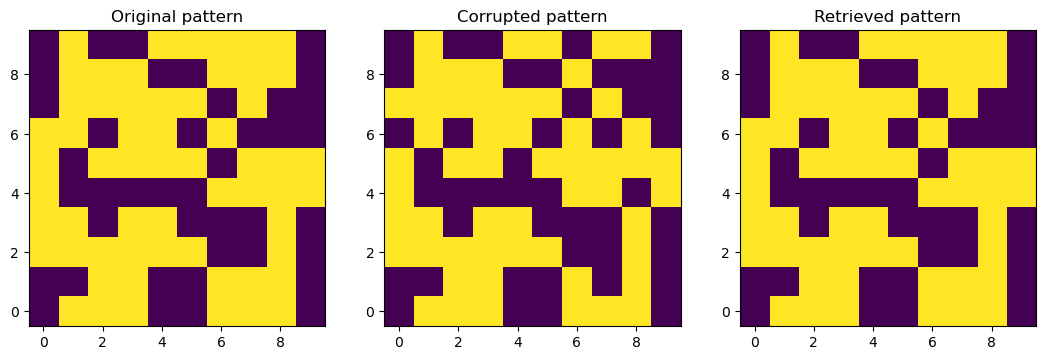

In [36]:
n_chosen = select_pattern_2d(patterns) #random select one pattern among the ones stored
q = 0.1 #fraction of spin flips
corrupted = pattern_corruption_2d(patterns[n_chosen],q) #corrupt it by flipping randomly the 10% of the spins

#we try to retrieve the the stored pattern using Metropolis algorithm:
T = 0.1
steps = 800
retrieved = metropolis_2d(corrupted,J,T,steps)
accuracy = mattis_overlap_2d(patterns[n_chosen],retrieved)

fig, ax = plt.subplots(1,3,figsize=(13,5))
ax[0].imshow(patterns[n_chosen], origin = 'lower')
ax[0].set_title('Original pattern')
ax[1].imshow(corrupted, origin = 'lower')
ax[1].set_title("Corrupted pattern")
ax[2].imshow(retrieved, origin = 'lower')
ax[2].set_title("Retrieved pattern")


print(f"Accuracy of the retrieval: {accuracy:.2f}")

As mentioned earlier, the stored patterns represent absolute (or relative) energy minima. We can observe how the energy of a pattern evolves with each iteration, gradually converging to the original pattern that existed before the corruption process. We can see this by applying a recursive procedure:

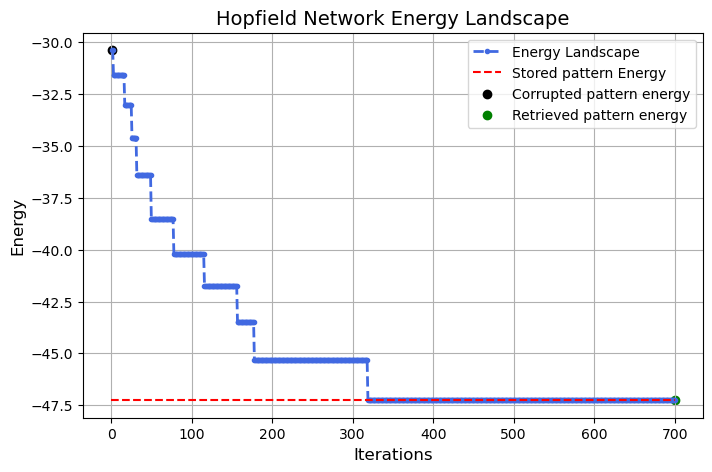

In [30]:
pattern_energy = compute_energy_2d(patterns[n_chosen], J)
energy_landscape = [] #save the energy after each iteration

for _ in range(700): 
    retrieved = metropolis_2d(corrupted, J, T, 1) #we perform only one iteration
    energy_landscape.append(compute_energy_2d(retrieved, J))
    corrupted = retrieved #update the corrupted pattern

iterations = np.linspace(1, 700, 700) #"x-axis" in the plot

# Plot energy landscape
#figure
plt.figure(figsize=(13, 5))
plt.grid()
plt.xlabel("Iterations", fontsize=12)
plt.ylabel("Energy", fontsize=12)
plt.title("Hopfield Network Energy Landscape", fontsize=14)

#data
plt.plot(iterations, energy_landscape, marker = 'o',linestyle="--", markersize = 3, label="Energy Landscape", 
         color="royalblue", linewidth=2)
plt.hlines(y=pattern_energy, xmin=0, xmax=700, colors="red", linestyle="--", label="Stored pattern Energy")
#Marking initial & final energy values
plt.scatter(1, energy_landscape[0], color='black', marker='o', label="Corrupted pattern energy")
plt.scatter(700, energy_landscape[-1], color='green', marker='o', label="Retrieved pattern energy")

plt.legend()



### Retrival ability varying the number of iterations

Now we check how "fast" (i.e. how many iterations) the network needs to reconstruct a corrupted version of a stored pattern:

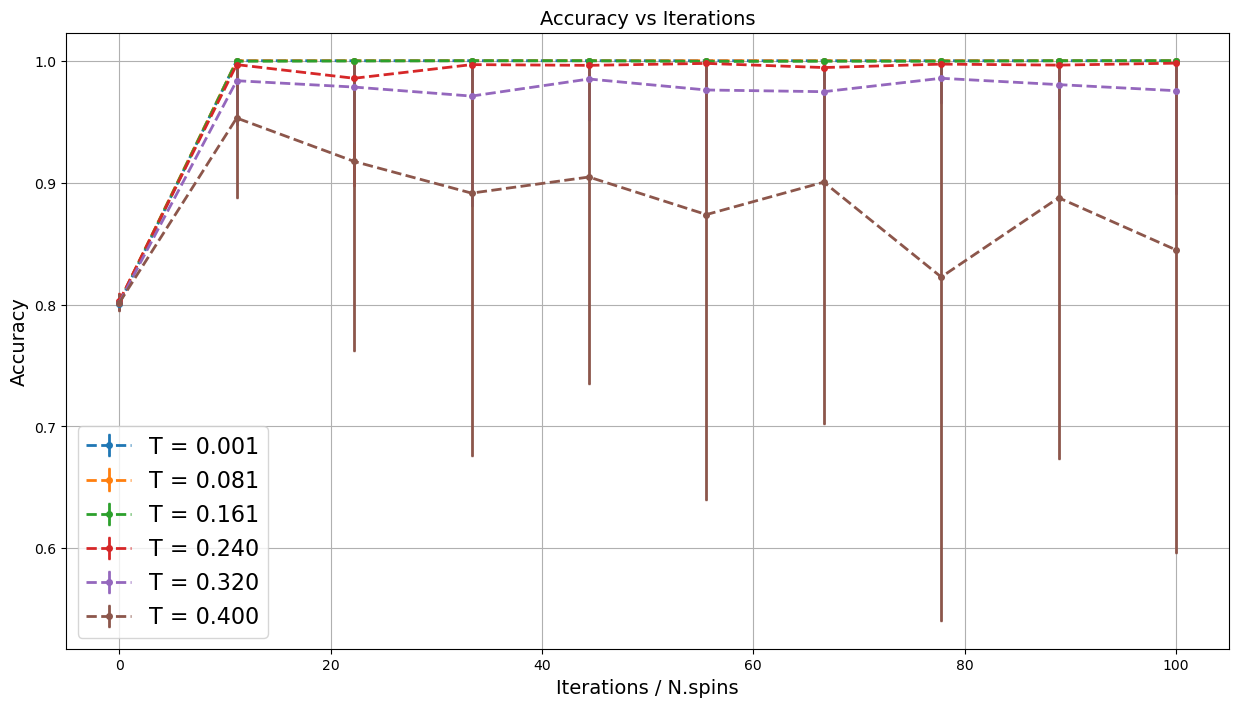

In [37]:
steps = np.linspace(1, 10000, 10, dtype='int')  #steps for the Metropolis algorithm
fractions = steps / (rows * columns)  #ratio between iterations and spins
T = np.linspace(0.001, 0.4, 6)  #range of temperatures to check

plt.figure(figsize=(15, 8))
for temperature in T:
    accuracy_list = []
    upper_errors = []
    lower_errors = []
    
    for step in steps:
        accuracy = []
        for _ in range(runs):
            i = select_pattern_2d(patterns)
            corrupted = pattern_corruption_2d(patterns[i], q)
            retrieved = metropolis_2d(corrupted, J, temperature, step)
            accuracy.append(mattis_overlap_2d(patterns[i], retrieved))
            
        accuracy_mean = np.mean(accuracy)
        accuracy_std = np.std(accuracy)
        
        # Compute physically meaningful error bars
        upper_err = min(accuracy_std, 1 - accuracy_mean)
        lower_err = accuracy_std
        
        accuracy_list.append(accuracy_mean)
        upper_errors.append(upper_err)
        lower_errors.append(lower_err)
    
    # Plotting with asymmetric error bars
    plt.errorbar(fractions, np.array(accuracy_list), yerr=[lower_errors, upper_errors], marker='o', linestyle="--", 
                 markersize=4, linewidth=2, label=f"T = {temperature:.3f}", capsize=1)

plt.grid()
plt.title("Accuracy vs Iterations", fontsize=14)
plt.xlabel("Iterations / N.spins", fontsize=14)
plt.ylabel("Accuracy", fontsize=14)
plt.legend(prop={'size': 16}, loc='best')

As we can see, within a "safe" temperature range and for the chosen percentage of spins flipped, convergence occurs after approximately ten times the number of spins involved. For instance, we can select 1000 iterations in the following.

### Retrieval ability varying q

<ErrorbarContainer object of 3 artists>

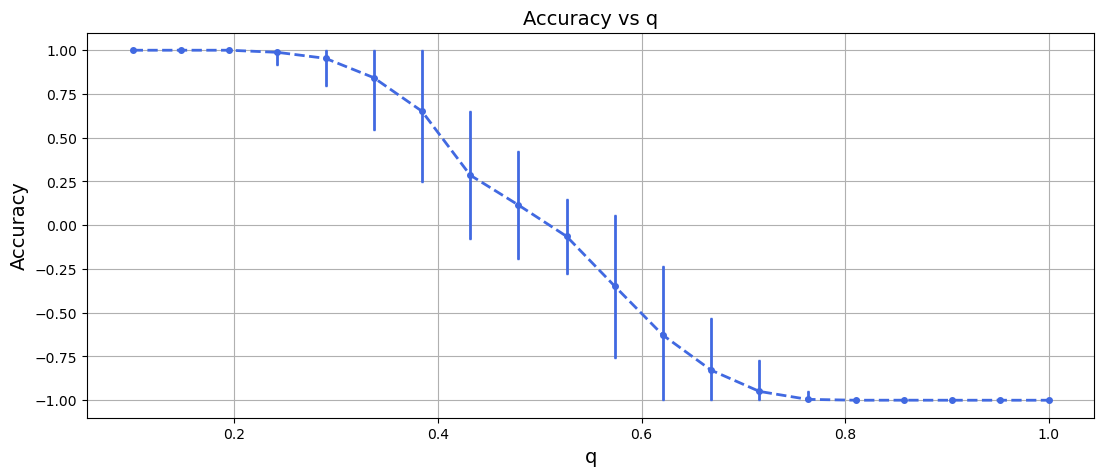

In [76]:
q_values = np.linspace(0.1,1,20) #different percentage of flips
steps = 1000 #steps for the Metropolis algorithm
T = 0.1
accuracy_list = [] 
upper_errors = []
lower_errors = []

for q in q_values:
    accuracy = []
    for _ in range(runs): #we compute the accuracy 150 times for each value of q and then compute the mean
        i = select_pattern_2d(patterns)
        corrupted = pattern_corruption_2d(patterns[i],q) # corrupt a spin with probability q
        retrieved = metropolis_2d(corrupted,J,T,steps)
        accuracy.append(mattis_overlap_2d(patterns[i],retrieved))
    accuracy = np.array(accuracy)
    accuracy_mean = np.mean(accuracy)
    accuracy_std = np.std(accuracy)
    
    # errors
    upper_err = min(accuracy_std, 1 - accuracy_mean)
    lower_err = min(accuracy_std, accuracy_mean + 1)
    
    accuracy_list.append(accuracy_mean)
    upper_errors.append(upper_err)
    lower_errors.append(lower_err)

#Plotting the results
plt.figure(figsize = (13,5))
plt.grid()
plt.title("Accuracy vs q", fontsize = 14)
plt.xlabel("q", fontsize = 14)
plt.ylabel("Accuracy", fontsize = 14)
plt.errorbar(q_values, np.array(accuracy_list), yerr=[lower_errors, upper_errors], marker='o', linestyle="--", markersize=4, 
            color="royalblue", linewidth=2, label="Accuracy vs q", capsize=1)

From the plot we can recognize different behaviours:

- If the random flip probability is low (approximately q $\leq$ 0.3) the network can retrieve the stored pattern with sufficent accuracy (more than 80%).
- If q $\approx$ 0.5, the accuracy il close to zero: this means the network can't recall the original pattern and outputs a random sequence of spins.
- Increasing further the value of q, the network tends to retrieve the original pattern, but with all the spins flipped.

This last point makes sense from a statistical mechanics perspective: The Ising model has $Z^2$ simmetry, and changing the sign of all the spins gives the same energy value.

## Accuracy varying $\alpha$

We now want to check how the retrieval capacity of the network varies basing on the number of stored patterns. Here $\alpha$ is the ratio between the number of stored patterns and the number N of spins. We will first check the retrieval success rate — how often the network retrieves the correct pattern - and then how precise is that retrieval:

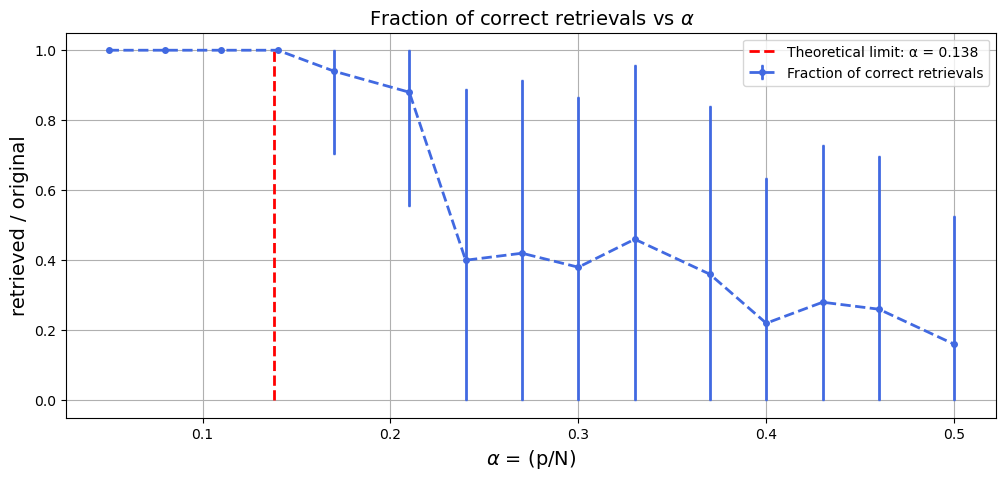

In [79]:
P = np.linspace(5, 50, 15, dtype=int)  # Array of pattern counts
rows, columns = 10, 10  # Number of spins in a pattern
T = 0.1
steps = 1000
alphas = []
patterns = []  # This will store patterns incrementally

#list for quantities we are interested in

accuracy_list = [] #precision of a retrieval
acc_upper_errors = []
acc_lower_errors = []

check_correctness = [] #fraction of correct retrievals
check_upper_errors = []
check_lower_errors = []


for p in P:
    np.random.seed(1234)  # Reset seed so old patterns are regenerated exactly
    patterns = create_patterns_2d(rows, columns, p)  
    J = compute_weights_2d(patterns)  
    accuracy = []
    correctness = []
    
    for _ in range(runs):  
        i = select_pattern_2d(patterns)
        corrupted = pattern_corruption_2d(patterns[i], 0.1)  # Corrupt 10% of spins
        retrieved = metropolis_2d(corrupted, J, T, steps)
        accuracy.append(mattis_overlap_2d(patterns[i], retrieved))
        overlaps_run = [] #list to store the overlaps
        for pattern in patterns:
            overlap = mattis_overlap_2d(retrieved, pattern)
            overlaps_run.append(overlap)  # Append each overlap to the list
        if np.argmax(overlaps_run) == i:  #if the index with highest overlap is equal to the chosen pattern 
            correctness.append(1.0)       #correct retrieval
        else:
            correctness.append(0.0)
        
        
    accuracy = np.array(accuracy)
    accuracy_mean = np.mean(accuracy)
    accuracy_std = np.std(accuracy)
    
    correctness = np.array(correctness)
    check_correctness_mean = np.mean(correctness)
    check_correctness_std = np.std(correctness)
    
    # errors
    acc_upper_err = min(accuracy_std, 1 - accuracy_mean)
    acc_lower_err = accuracy_std
    check_upper_err = min(check_correctness_std, 1 - check_correctness_mean)
    check_lower_err = min(check_correctness_std, check_correctness_mean)
    
    #append to lists
    accuracy_list.append(accuracy_mean)
    acc_upper_errors.append(acc_upper_err)
    acc_lower_errors.append(acc_lower_err)
    
    check_correctness.append(check_correctness_mean)
    check_upper_errors.append(check_upper_err)
    check_lower_errors.append(check_lower_err)
    
    alphas.append(p / (rows * columns))  # Compute α = p/N

# Plot results
plt.figure(figsize=(12, 5))
plt.grid()
plt.title(r"Fraction of correct retrievals vs $\alpha$", fontsize=14)
plt.xlabel(r"$\alpha$ = (p/N)", fontsize=14)
plt.ylabel("retrieved / original", fontsize=14)

plt.errorbar(alphas, np.array(check_correctness), yerr=[check_lower_errors, check_upper_errors], marker='o', linestyle="--", markersize=4, 
            color="royalblue", linewidth=2, label="Fraction of correct retrievals", capsize=1)
plt.vlines(x=0.138, ymin=0.0, ymax=1, linestyle="--", color="red", label="Theoretical limit: α = 0.138", linewidth=2)

plt.legend(loc="best")

We have found that we have a sufficient good retrieval for values of $\alpha$ < 0.20. Now we can make a more accurate scan, plotting how precise is the retrieval of the network in that region of $\alpha$:

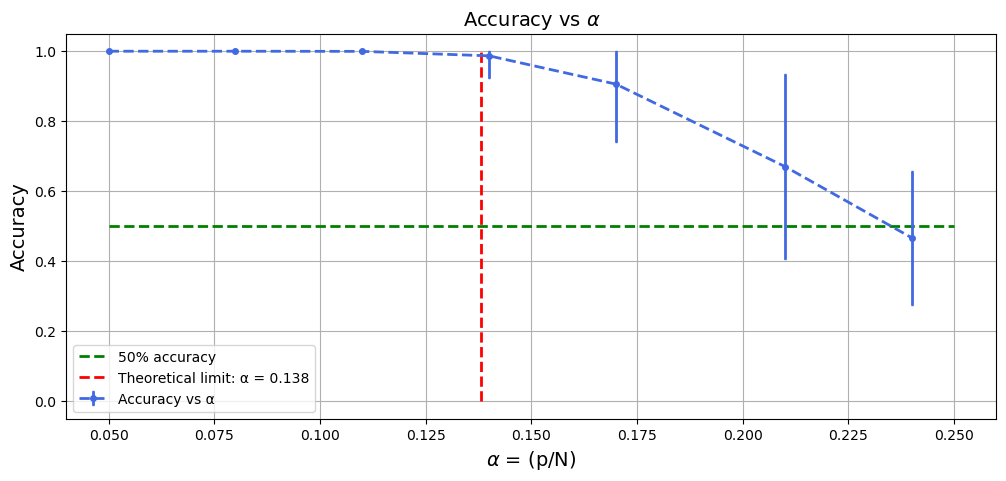

In [83]:
plt.figure(figsize=(12, 5))
plt.grid()
plt.title(r"Accuracy vs $\alpha$", fontsize=14)
plt.xlabel(r"$\alpha$ = (p/N)", fontsize=14)
plt.ylabel("Accuracy", fontsize=14)

#transformed to array to create a mask
alphas = np.array(alphas) 
acc_lower_errors = np.array(acc_lower_errors)
acc_upper_errors = np.array(acc_upper_errors)

mask = alphas < 0.25
plt.hlines(y=0.5, xmin=alphas[0], xmax=0.25, color="green", linewidth=2, linestyle="--", label = '50% accuracy')
plt.vlines(x=0.138, ymin=0.0, ymax=1, linestyle="--", color="red", label="Theoretical limit: α = 0.138", linewidth=2)
plt.errorbar(alphas[mask], np.array(accuracy_list)[mask], yerr=[acc_lower_errors[mask], acc_upper_errors[mask]], marker='o', linestyle="--", markersize=4, 
            color="royalblue", linewidth=2, label="Accuracy vs α", capsize=1)

plt.legend(loc="best")

As we can see, in this particular case, there is good agreement with the theoretical result ($\alpha = 0.138$) for a perfect retrieval. However, it is important to note that the retrieval capacity of a Hopfield network also strongly depends on the nature and correlations of the stored patterns. Due to this, in some cases, the network’s retrieval performance may be better or worse than the theoretical prediction.

### Overlaps for different values of $\alpha$

We can check also in this situation the overlap between the retrieved pattern and the stored ones for $\alpha = 0.1$ and $\alpha = 0.4$:

For α = 0.1: selected pattern number: 6
For α = 0.4: selected pattern number: 39


For α = 0.1: retrieved pattern number: 6
For α = 0.4: retrieved pattern number: 17


Text(0, 0.5, 'Overlap')

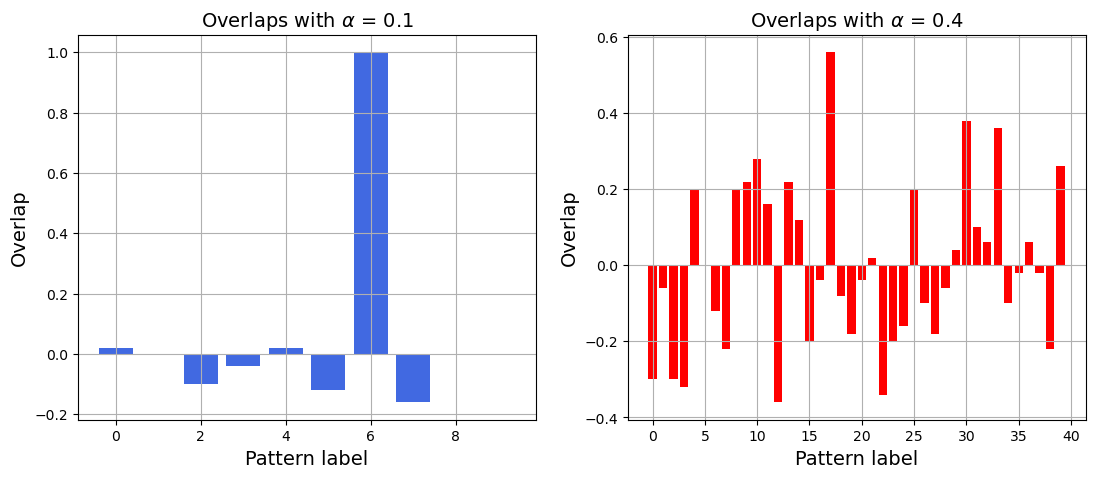

In [50]:
rows, columns = 10, 10
alphas = [0.1,0.4]
overlap_01 = []
overlap_04 = []
T = 0.1
steps = 1000

for alpha in alphas: 
    N_patterns = int(alpha * rows * columns)
    patterns = create_patterns_2d(rows,columns,N_patterns)
    J = compute_weights_2d(patterns)
    n = select_pattern_2d(patterns) #choose a random pattern
    retrieved = metropolis_2d(patterns[n],J,T,steps)
    for pattern in patterns:
        overlap = mattis_overlap_2d(retrieved,pattern)
        if (alpha == 0.1):
            overlap_01.append(overlap)
        else: 
            overlap_04.append(overlap)
    print(fr"For α = {alpha}: selected pattern number: {n}")
print("\n")
print(fr"For α = {alphas[0]}: retrieved pattern number: {np.argmax(overlap_01)}")
print(fr"For α = {alphas[1]}: retrieved pattern number: {np.argmax(overlap_04)}")


#visualization:
fig, ax = plt.subplots(1,2,figsize = (13,5))
#alpha = 0.1
ax[0].grid()
ax[0].bar(range(len(overlap_01)), overlap_01, color="royalblue")
ax[0].set_title(r"Overlaps with $\alpha$ = 0.1", fontsize = 14)
ax[0].set_xlabel("Pattern label", fontsize = 14)
ax[0].set_ylabel("Overlap", fontsize = 14)
#alpha = 0.4
ax[1].grid()
ax[1].bar(range(len(overlap_04)), overlap_04, color="red")
ax[1].set_title(r"Overlaps with $\alpha$ = 0.4", fontsize = 14)
ax[1].set_xlabel("Pattern label", fontsize = 14)
ax[1].set_ylabel("Overlap", fontsize = 14)

As expected, the overlap between patterns increases as $\alpha$ increases. While the network may still be able to retrieve the correct pattern in some cases as we have seen in the previous plots, it does so with a significant loss of information (i.e. incorrect spin flips), likely caused by similarities with other stored patterns.

## Time complexity

The last part on this section is about time complexity of the Monte Carlo algorithm for retrieval process:

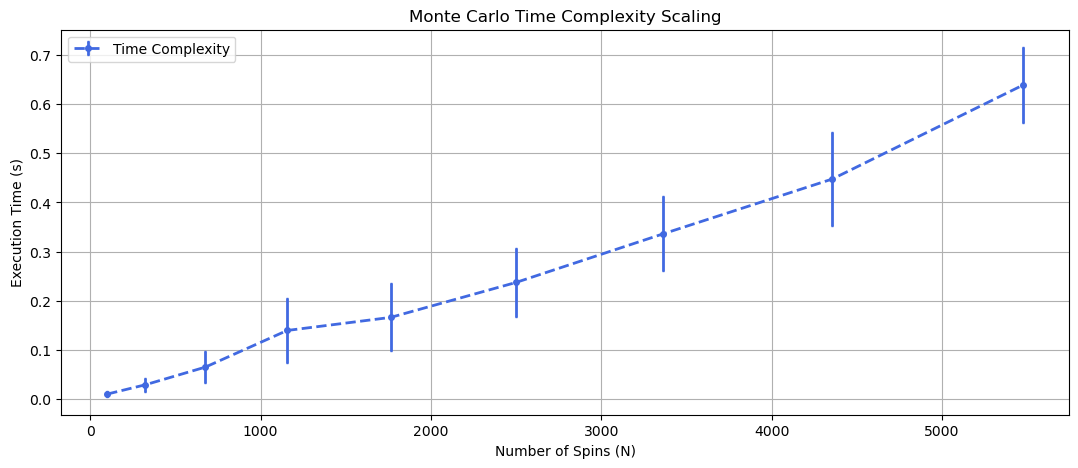

In [78]:
import time
T = 0.1  
N_values = np.arange(10, 80, 8)  # Different spin system sizes
N_patterns = 10
times = []
error_times = []
runs = 50
for N in N_values:
    appending_time = []
    for _ in range(runs):
        patterns = create_patterns_2d(N, N, N_patterns)  # Generate patterns
        weights = compute_weights_2d(patterns)  # Compute weights
        i = select_pattern_2d(patterns)  # Select a pattern
        corrupted = pattern_corruption_2d(patterns[i], q=0.1)  # Corrupt it

        steps = 5 * N * N  # Interactions are always 5 * N**2

        start_time = time.time()
        metropolis_2d(corrupted, weights, T, steps)  # Run Monte Carlo
        appending_time.append(time.time() - start_time)
    appending_time = np.array(appending_time)
    times.append(np.mean(appending_time))
    error_times.append(np.std(appending_time))

plt.figure(figsize=(13,5))
plt.grid()
plt.errorbar(N_values**2, times, yerr=error_times, linestyle="--", color='royalblue', marker = 'o', markersize = 4, capsize = 1, 
             linewidth=2, label='Time Complexity')
plt.xlabel('Number of Spins (N)')
plt.ylabel('Execution Time (s)')
plt.title('Monte Carlo Time Complexity Scaling')
plt.legend()

We see that this algorithm is approximately O(N).